<a href="https://colab.research.google.com/github/dotlincu/project-ml-classification/blob/main/projeto_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classificando o Ódio - análise de discurso de ódio em comentários do YouTube

# **1. Introdução**

## **1.1 Contexto**
O discurso de ódio nas redes sociais tem se tornado um problema crescente, exigindo soluções eficazes para detecção e moderação automática. O objetivo deste projeto é desenvolver um modelo de aprendizado de máquina capaz de identificar e classificar automaticamente discursos de ódio em textos.

## **1.2 Objetivo do Projeto**
Criar um modelo de classificação que possa distinguir entre textos ofensivos e não ofensivos, utilizando técnicas de aprendizado de máquina e processamento de linguagem natural (NLP).

## **1.3 Estrutura do Relatório**
O notebook/relatório apresenta o pipeline adotado, abordando desde a coleta e processamento dos dados até a construção e avaliação dos modelos.

---

# **2. Metodologia**

## **2.1 Pipeline do Projeto**
1. **Coleta de Dados:** Conjunto de dados não rotulados de comentários do YouTube.
2. **Pré-processamento:** Limpeza, lematização e remoção de stopwords.
3. **Pseudo-rotulação:** Uso de modelo pré-treinado para rotular dados com confiança acima de 90%.
4. **Engenharia de Features:** Representação do texto usando Bag of Words e TF-IDF.
5. **Definição do Baseline:** Treinamento de modelos simples (Random Forest e Logistic Regression) para referência.
6. **Treinamento do Modelo Final:** Fine-tuning do BERTimbau.
7. **Avaliação:** Uso de métricas como precisão, recall, F1-score e Kappa de Cohen.

## **2.2 Pré-processamento e Engenharia de Features**
- **Remoção de URLs, números, caracteres especiais e stopwords.**
- **Lematização:** Uso do SpaCy para lematização em português.
- **Bag of Words:** Captura a quantidade de palavras no texto.
- **Representação TF-IDF:** Captura a importância relativa das palavras.
- **Word Embeddings (BERTimbau):** Representação semântica mais rica para classificação.

---

# **3. Desenvolvimento**

## **3.1 Pseudo-Rotulação**
- Modelo pré-treinado com F1-score de 76%.
- Apenas exemplos com confiança acima de 90% foram usados para treinar o modelo final.
- Utilização da métrica Kappa de Cohen para verificação de qualidade de rotulação.

## **3.3 Avaliação da Qualidade da Rotulação**
Para avaliar a concordância entre os rótulos gerados pelo modelo pré-treinado e a anotação manual, utilizamos o coeficiente Kappa de Cohen.

- O valor do Kappa de Cohen entre um anotador humano e o modelo pré-treinado foi **0.67**, indicando um nível de concordância moderado.
- A tabela a seguir apresenta a interpretação dos valores de Kappa e a porcentagem estimada de dados confiáveis:

| Valor do Kappa  | Nível de Concordância | Porcentagem de Dados Confiáveis |
|----------------|----------------------|--------------------------------|
| 0 a 0,20      | Nenhum                | 0 a 4                          |
| 0,21 a 0,39   | Mínimo                | 4 a 15                         |
| 0,40 a 0,59   | Fraco                 | 15 a 35                        |
| 0,60 a 0,79   | Moderado              | 35 a 63                        |
| 0,80 a 0,90   | Forte                 | 64 a 81                        |
| Acima de 0,90 | Quase perfeito        | 82 a 100                       |

Fonte: McHugh, M. L. (2012). Interrater reliability: The kappa statistic. Biochemia Medica, 22(3), 276–282.

## **3.3 Construção do Modelo Baseline**
- **Modelos testados:**
  - Random Forest
  - Logistic Regression
- **Justificativa:** Modelos leves e interpretáveis para comparação inicial.
- **Métricas obtidas:**
  - Random Forest: F1-score = 0.84
  - Logistic Regression: F1-score = 0.85

## **3.4 Treinamento do Modelo Final**
- **Modelo:** BERTimbau (modelo baseado em BERT para português).
- **Ajustes:** Fine-tuning nas camadas superiores.
- **Validação Cruzada:** K-fold para garantir maior robustez nos resultados.

---

# **4. Avaliação dos Modelos**

## **4.1 Métricas Utilizadas**
- **Precisão:** Mede a proporção de predições corretas.
- **Recall:** Mede a capacidade de detectar discursos de ódio.
- **F1-score:** Equilíbrio entre precisão e recall.
- **Kappa de Cohen:** Mede a concordância entre os rótulos preditos e manuais.

---

# **5. Trabalhos Futuros**

## **5.1 Trabalhos Futuros**
- Coletar dados específicos do período eleitoral, onde há uma possível maior incidência de comentários tóxicos devido ao aumento das discussões políticas polarizadas.
- Implementar o modelo final utilizando BERTimbau.
- Avaliar e comparar os modelos baseline e final.
- Explorar outras arquiteturas baseadas em transformers para refinamento do modelo.

---

**Autor:** Lincoln Rebouças

## Importação de bibliotecas

In [431]:
# Importações Básicas
import pandas as pd
import random
import numpy as np
import csv
import re
import spacy

# Visualização de Dados
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
from spacy.lang.pt.stop_words import STOP_WORDS as STOPWORDS
# from tabulate import tabulate

from sklearn.metrics import cohen_kappa_score

# Integração com Google Drive
from google.colab import drive, files
drive.mount('/content/drive')

# Processamento de Linguagem Natural (NLP)
from collections import Counter
import nltk
from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [234]:
# Verificação e Download de Recursos do NLTK
nltk.download('punkt')          # Para tokenização
nltk.download('stopwords')      # Para remoção de stopwords

# Carregar o modelo em português do SpaCy
!python -m spacy download pt_core_news_sm
nlp = spacy.load("pt_core_news_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 100.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [235]:
stopwords_pt = stopwords.words('portuguese')
stopwords = set(stopwords_pt)

**KEY_WORDS** = ["eleições 2022", "presidente", "Lula", "Bolsonaro", "debate", "voto", "urnas", "política"]

**QUERIES** = ["eleições 2022", "Lula presidente", "Bolsonaro presidente", "debate eleitoral 2022", "votação 2022", "urnas eletrônicas"]


## Importação de Dataset

In [287]:
df = pd.read_csv('/content/drive/MyDrive/ML/comments_info.csv', sep=',')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65910 entries, 0 to 65909
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   video_id                  65910 non-null  object
 1   comment_id                65910 non-null  object
 2   author                    65840 non-null  object
 3   author_profile_image_url  65910 non-null  object
 4   author_channel_url        65910 non-null  object
 5   author_channel_id         65910 non-null  object
 6   comment                   65902 non-null  object
 7   published_at              65910 non-null  object
 8   updated_at                65910 non-null  object
 9   like_count                65910 non-null  int64 
 10  viewer_rating             65910 non-null  object
 11  can_rate                  65910 non-null  bool  
 12  is_reply                  65910 non-null  bool  
 13  parent_id                 18794 non-null  object
 14  channel_id            

In [288]:
df.columns

Index(['video_id', 'comment_id', 'author', 'author_profile_image_url',
       'author_channel_url', 'author_channel_id', 'comment', 'published_at',
       'updated_at', 'like_count', 'viewer_rating', 'can_rate', 'is_reply',
       'parent_id', 'channel_id'],
      dtype='object')

In [289]:
df.drop(['video_id', 'comment_id', 'author', 'author_profile_image_url',
       'author_channel_url', 'author_channel_id', 'published_at',
       'updated_at', 'like_count', 'viewer_rating', 'can_rate', 'is_reply',
       'parent_id', 'channel_id'], axis=1, inplace=True)
df.head()

,comment
0,"GENTE UMA DÚVIDA, NOS EDITAIS DE CONCURSO DA F..."
1,BANDIDOS
2,"Viva Lula, viva Alckmin, viva a Democracia. Pa..."
3,Alexandre de Moraes bandido O Ladrão
4,Não podemos deixar um ministro vagabundo mand...


## Análise Exploratória de Dados (EDA)

In [290]:
df.isna().sum()

,0
comment,8


In [291]:
df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65902 entries, 0 to 65909
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  65902 non-null  object
dtypes: object(1)
memory usage: 1.0+ MB


In [292]:
df.duplicated().sum()

2233

In [293]:
df.drop_duplicates(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63669 entries, 0 to 65887
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  63669 non-null  object
dtypes: object(1)
memory usage: 994.8+ KB


In [294]:
df.shape

(63669, 1)

## Pré-processamento de Texto

In [295]:
# Função para limpar o texto
def clean_text(text):
    text = re.sub(r'https?:\/\/\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)         # Remove pontuação
    text = re.sub(r'\d+', '', text)             # Remove números
    return text.lower()                         # Converte para minúsculas

# Função para lematizar o texto em lotes e converter para minúsculas
def lemmatize_batch(texts):
    docs = nlp.pipe(texts, batch_size=50)       # Processa em lotes de 50 textos
    lemmas = [" ".join([token.lemma_ for token in doc]).lower() for doc in docs]  # Converte para minúsculas
    return lemmas

In [296]:
# Aplicando a limpeza
df['comment'] = df['comment'].apply(clean_text)

# Aplicando a lematização
# df['comment'] = df['comment'].apply(lemmatize_text)

# Aplicando a lematização em lotes
# df['comment'] = lemmatize_batch(df['comment'])

# Concatenando os textos em uma única string
string = ' '.join(df['comment'])

# Removendo caracteres indesejados
for char in "#@\n":
    string = string.replace(char, '')

In [297]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63669 entries, 0 to 65887
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  63669 non-null  object
dtypes: object(1)
memory usage: 994.8+ KB


In [247]:
df.to_csv("/content/drive/MyDrive/ML/df.csv", index=False)
# files.download("df_sample.csv")

## Nuvem de palavras

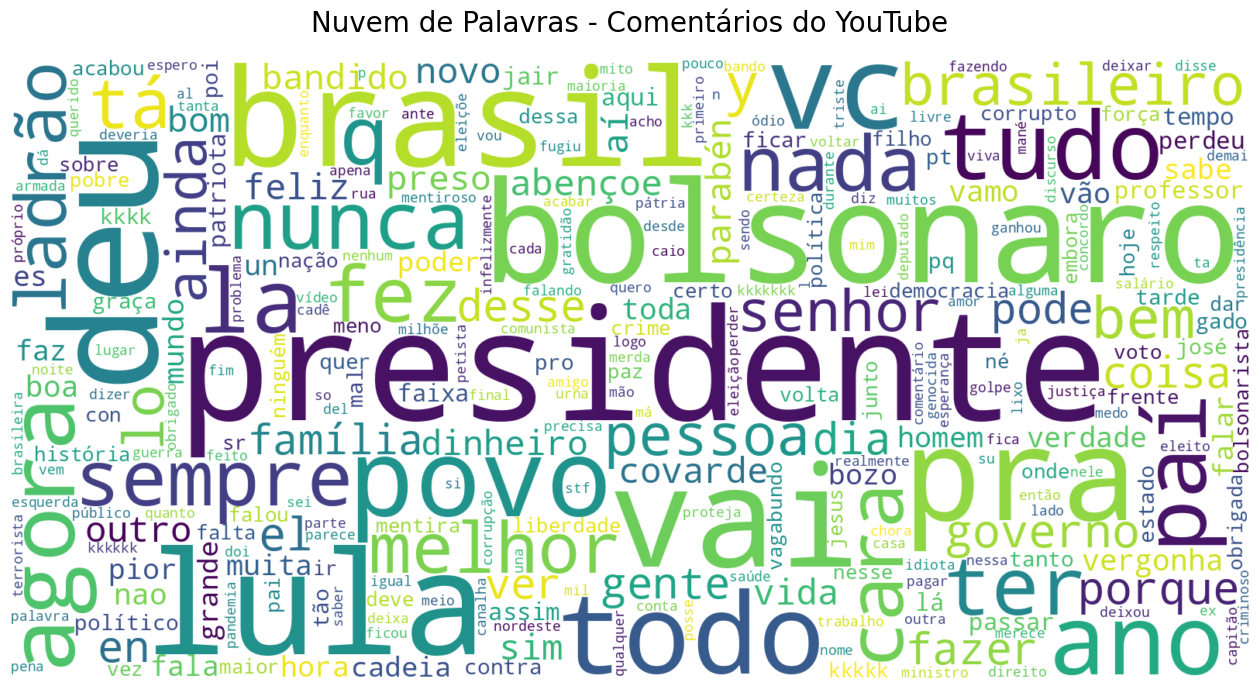

In [298]:
# Gerando a nuvem de palavras
wordcloud = WordCloud(
    width=1600,
    height=800,
    max_font_size=200,
    max_words=300,
    stopwords=stopwords,
    collocations=False,
    background_color='white'
).generate(string)

# Exibindo o resultado
plt.figure(figsize=(16,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuvem de Palavras - Comentários do YouTube", fontsize=20, pad=20)
plt.show()

In [299]:
# Contando palavras ignorando stopwords
words = [word for word in string.split() if word not in stopwords]
word_counts = Counter(words)

# Exibindo as 10 palavras mais frequentes
print(word_counts.most_common(20))

[('presidente', 8878), ('lula', 7708), ('vai', 7303), ('bolsonaro', 7300), ('deus', 7279), ('brasil', 6865), ('pra', 6242), ('povo', 4318), ('vc', 3989), ('todos', 3198), ('tudo', 3144), ('agora', 3019), ('país', 2799), ('q', 2476), ('ter', 2328), ('nunca', 2314), ('sempre', 2300), ('la', 2297), ('nada', 2229), ('cara', 2215)]


## Divisão dos dados para pseudo-rotulação

In [302]:
random_seed = random.randint(1, 100)
print("Número aleatório utilizado:", random_seed)

Número aleatório utilizado: 36


In [318]:
df_sample = df.sample(frac=0.2, random_state=42)
df_sample.head()

,comment
5659,fez certoele tá com vergonha de passar a faixa...
39620,espero que bolsonaro se arrependa de todo o ma...
61193,
42710,parabéns ao presidente do tcu me representa
14175,deus nus deu de presente lula o melhor preside...


In [319]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12734 entries, 5659 to 13342
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  12734 non-null  object
dtypes: object(1)
memory usage: 199.0+ KB


In [320]:
df_sample.isna().sum()

,0
comment,0


In [321]:
df_sample.dropna(inplace=True)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12734 entries, 5659 to 13342
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  12734 non-null  object
dtypes: object(1)
memory usage: 199.0+ KB


In [322]:
df_sample.to_csv("/content/drive/MyDrive/ML/df_sample.csv", index=False)
# files.download("df_sample.csv")

## Importação do Modelo Pré-Treinado ToLD-Br - BERT for PT-BR Toxic Tweets

In [20]:
# install dependencies
%%writefile setup.sh

export CUDA_HOME=/usr/local/cuda-10.1
git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex --quiet
pip install simpletransformers --quiet
pip install unidecode --quiet
pip install gdown --quiet

Writing setup.sh


In [23]:
!sh setup.sh

fatal: destination path 'apex' already exists and is not an empty directory.
DEPRECATION: --build-option and --global-option are deprecated. pip 24.2 will enforce this behaviour change. A possible replacement is to use --config-settings. Discussion can be found at https://github.com/pypa/pip/issues/11859
Processing ./apex
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [24]:
import os
from simpletransformers.classification import ClassificationModel
from google.colab import drive, files
import gdown

url = "https://drive.google.com/uc?id=1Q8MuO4SsND0xzDIW9TNvzfl5Fc2NGwAJ"
output = "toxic_bert_model.zip"
gdown.download(url, output, quiet=True)

os.environ['modelpath'] = "./toxic_bert_model.zip"

In [25]:
!unzip "$modelpath" -d .

Archive:  ./toxic_bert_model.zip
   creating: ./toxic_bert_model/
  inflating: ./toxic_bert_model/vocab.txt  
  inflating: ./toxic_bert_model/config.json  
 extracting: ./toxic_bert_model/tokenizer_config.json  
  inflating: ./toxic_bert_model/model_args.json  
  inflating: ./toxic_bert_model/pytorch_model.bin  
  inflating: ./toxic_bert_model/training_args.bin  
  inflating: ./toxic_bert_model/special_tokens_map.json  


In [200]:
import torch
print(torch.cuda.is_available())

True


In [201]:
# Em use_cuda use True quando GPU ativada e False quando GPU desativada
told_model = ClassificationModel("distilbert", "toxic_bert_model", use_cuda=True)

In [202]:
# predictions, outputs = told_model.predict(["este é um exemplo."])

# print("Predictions:", predictions)
# print("Outputs:", outputs)

## Pseudo-rotulação

In [308]:
import numpy as np

def softmax(x):
    exp_x = np.exp(x - np.max(x))  # Evitar overflow
    return exp_x / exp_x.sum()

In [309]:
# Função para gerar pseudo-rótulos
def pseudo_label(data, model, threshold=0.9):
    pseudo_labels = []
    predictions, raw_outputs = model.predict(data)      # Fazer previsões para todos os textos de uma vez

    for i, text in enumerate(data):
        prob = softmax(raw_outputs[i])                  # Converter saídas brutas em probabilidades
        predicted_label = predictions[i]
        confidence = max(prob)                          # Confiança da previsão

        if confidence >= threshold:                     # Usar apenas previsões confiáveis
            pseudo_labels.append(predicted_label)
        else:
            pseudo_labels.append(None)                  # Ignorar previsões não confiáveis

    return pseudo_labels

In [323]:
# df_sample = pd.read_csv('/content/drive/MyDrive/ML/df_sample.csv', sep=',')
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12734 entries, 5659 to 13342
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   comment  12734 non-null  object
dtypes: object(1)
memory usage: 199.0+ KB


In [324]:
# Verificar o número de comentários não rotulados
print("Número de comentários não rotulados:", len(df_sample['comment']))

Número de comentários não rotulados: 12734


In [325]:
# Aplicar pseudo-rotulação a uma parte dos dados não rotulados
unlabeled_data = df_sample['comment'].tolist()
pseudo_labels = pseudo_label(unlabeled_data, told_model)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1592 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/simpletransformers/classification/classification_model.py:2188: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast():


In [326]:
df_sample['pseudo_label'] = pseudo_labels

In [327]:
df_sample.head()

,comment,pseudo_label
5659,fez certoele tá com vergonha de passar a faixa...,0.0
39620,espero que bolsonaro se arrependa de todo o ma...,NaN
61193,,NaN
42710,parabéns ao presidente do tcu me representa,0.0
14175,deus nus deu de presente lula o melhor preside...,0.0


In [328]:
print("Quantidade total:", len(pseudo_labels))
print("Quantidade de 1's:", pseudo_labels.count(1))
print("Quantidade de 0's:", pseudo_labels.count(0))
print("Quantidade ignorada:", pseudo_labels.count(None))

Quantidade total: 12734
Quantidade de 1's: 876
Quantidade de 0's: 6934
Quantidade ignorada: 4924


In [330]:
df_sample['pseudo_label'].value_counts(normalize=True)

,proportion
pseudo_label,
0.0,0.887836
1.0,0.112164


## Comparação Kappa de Cohen

In [331]:
df_filtered = df_sample.dropna(subset=['pseudo_label'])
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7810 entries, 5659 to 13342
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   comment       7810 non-null   object 
 1   pseudo_label  7810 non-null   float64
dtypes: float64(1), object(1)
memory usage: 183.0+ KB


In [ ]:
# df_manual_labels.to_csv("df_filtered.csv", index=False)
# files.download("df_filtered.csv")

In [340]:
df_manual_labels = df_filtered.sample(frac=0.05, random_state=42)
df_manual_labels.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 800 to 1587
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   comment       392 non-null    object 
 1   pseudo_label  392 non-null    float64
dtypes: float64(1), object(1)
memory usage: 9.2+ KB


In [ ]:
df_manual_labels.to_csv("comments_manual_labels.csv", index=False)
files.download("comments_manual_labels.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [341]:
df_manual_labels_ = pd.read_csv('/content/drive/MyDrive/ML/comments_manual_labels_.csv', sep=',')
df_manual_labels_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         392 non-null    int64  
 1   comment       392 non-null    object 
 2   pseudo_label  392 non-null    float64
 3   manual_label  392 non-null    int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 12.4+ KB


In [342]:
df_manual_labels_.drop(['index'], axis=1, inplace=True)
df_manual_labels_['pseudo_label'] = df_manual_labels_['pseudo_label'].astype(int)
df_manual_labels_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   comment       392 non-null    object
 1   pseudo_label  392 non-null    int64 
 2   manual_label  392 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 9.3+ KB


In [343]:
df_manual_labels_['pseudo_label'].value_counts(normalize=True)

,proportion
pseudo_label,
0,0.867347
1,0.132653


In [344]:
df_manual_labels_['manual_label'].value_counts(normalize=True)

,proportion
manual_label,
0,0.780612
1,0.219388


McHugh (2012) fornece orientações para interpretação do valor do kappa de Cohen, conforme nossa reprodução na tabela.

| Valor do kappa  | Nível de concordância | Porcentagem de dados confiáveis |
|----------------|----------------------|--------------------------------|
| 0 a 0,20      | Nenhum                | 0 a 4                          |
| 0,21 a 0,39   | Mínimo                | 4 a 15                         |
| 0,40 a 0,59   | Fraco                 | 15 a 35                        |
| 0,60 a 0,79   | Moderado              | 35 a 63                        |
| 0,80 a 0,90   | Forte                 | 64 a 81                        |
| Acima de 0,90 | Quase perfeito        | 82 a 100                       |

McHugh, M. L. (2012). Interrater reliability: The kappa statistic. Biochemia Medica, 22(3), 276–282.

In [353]:
kappa = cohen_kappa_score(df_manual_labels_['pseudo_label'], df_manual_labels_['manual_label'])
print(f"Kappa de Cohen: {kappa: .2f}")

Kappa de Cohen:  0.67


In [359]:
df_discrepancies = df_manual_labels_[df_manual_labels_['pseudo_label'] != df_manual_labels_['manual_label']]
print("Casos de discordância:")
df_discrepancies[['comment', 'pseudo_label', 'manual_label']]

Casos de discordância:


,comment,pseudo_label,manual_label
5,agiu com o psicopata deixou aquela gente no so...,0,1
18,pega o beco preguiçoso,0,1
19,verás que um patriotario foge à luta,0,1
31,só por deus um ladrão governando a presidência...,0,1
42,reunião de ladrões é quadrilha ele não faria m...,0,1
71,receber r para o resto da vida esse é o fruto...,0,1
76,fez certo passar a faixa para um bandido ex p...,0,1
115,noooooooosssssaaaaaa e tanta gente que mal da ...,0,1
116,danielejansons os dias melhores começou com o ...,0,1
133,covardia e traição às pessoas que votaram nele...,0,1


## Preparação dos dados para treinamento

In [390]:
df_filtered.value_counts('pseudo_label')

,count
pseudo_label,
0.0,6934
1.0,876


In [391]:
df_true = df_filtered[df_filtered['pseudo_label'] == 1]
df_true.shape

(876, 2)

In [392]:
df_false = df_filtered[df_filtered['pseudo_label'] == 0]
df_false_downsampled = df_false.sample(df_true.shape[0], random_state=random_seed)
df_false_downsampled.shape

(876, 2)

In [393]:
df_balanced = pd.concat([df_true, df_false_downsampled])
df_balanced.shape

(1752, 2)

In [395]:
X = df_balanced['comment']
y = df_balanced['pseudo_label'].astype(int)

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed)

In [397]:
print("Dados de treino:", X_train.shape)
print("Dados de teste:", X_test.shape)

Dados de treino: (1401,)
Dados de teste: (351,)


In [399]:
y_train.value_counts(normalize=True)

,proportion
pseudo_label,
0,0.500357
1,0.499643


In [400]:
y_test.value_counts(normalize=True)

,proportion
pseudo_label,
1,0.501425
0,0.498575


### Bag of Words

In [439]:
# Bag of Words
cv = CountVectorizer()

X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(1401, 5367)

In [440]:
X_test_cv = cv.transform(X_test)
X_test_cv.shape

(351, 5367)

### TF-IDF

In [432]:
# TF-IDF
tfidf = TfidfVectorizer()

X_train_tfidf = tfidf.fit_transform(X_train)
X_train_tfidf.shape

(1401, 5367)

In [441]:
X_test_tfidf = tfidf.transform(X_test)
X_test_tfidf.shape

(351, 5367)

## Treinamento do modelo - Logistic Regression

In [450]:
lr = LogisticRegression()
lr.fit(X_train_cv, y_train)

LogisticRegression()

In [451]:
y_pred_lr = lr.predict(X_test_cv)

## Avaliação do modelo - Logistic Regression

In [452]:
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       175
           1       0.88      0.81      0.85       176

    accuracy                           0.85       351
   macro avg       0.85      0.85      0.85       351
weighted avg       0.85      0.85      0.85       351



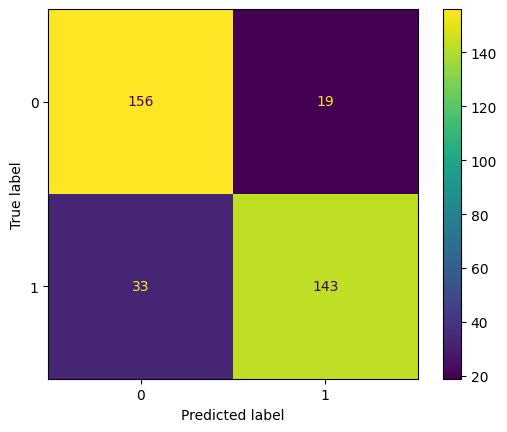

In [422]:
cm = confusion_matrix(y_test, y_pred_lr)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Treinamento do modelo - Random Forest

In [436]:
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [442]:
y_pred_rf = rf.predict(X_test_tfidf)

## Avaliação do modelo - Random Forest

In [443]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       175
           1       0.87      0.81      0.84       176

    accuracy                           0.84       351
   macro avg       0.84      0.84      0.84       351
weighted avg       0.84      0.84      0.84       351



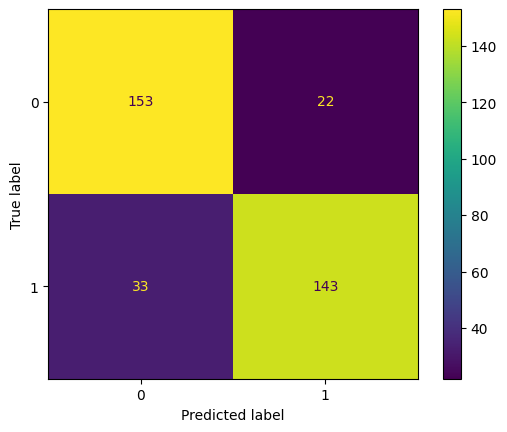

In [445]:
cm = confusion_matrix(y_test, y_pred_rf)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

## Rotulação do restante dos dados

## Análise de resultado